C:\Users\Spark\AppData\Local\Temp\ipykernel_19980\3586673055.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cifar10_cnn_0.78.pth'))


Files already downloaded and verified
Predicted labels:  [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 5 8 6 7 0 0 9 4 4 4 0 9 6 6 4 4 5 9 9 4
 1 9 5 4 6 5 6 1 9 5 3 7 4 9 8 7 3 8 8 7 3 3 3 7 5 2 3]


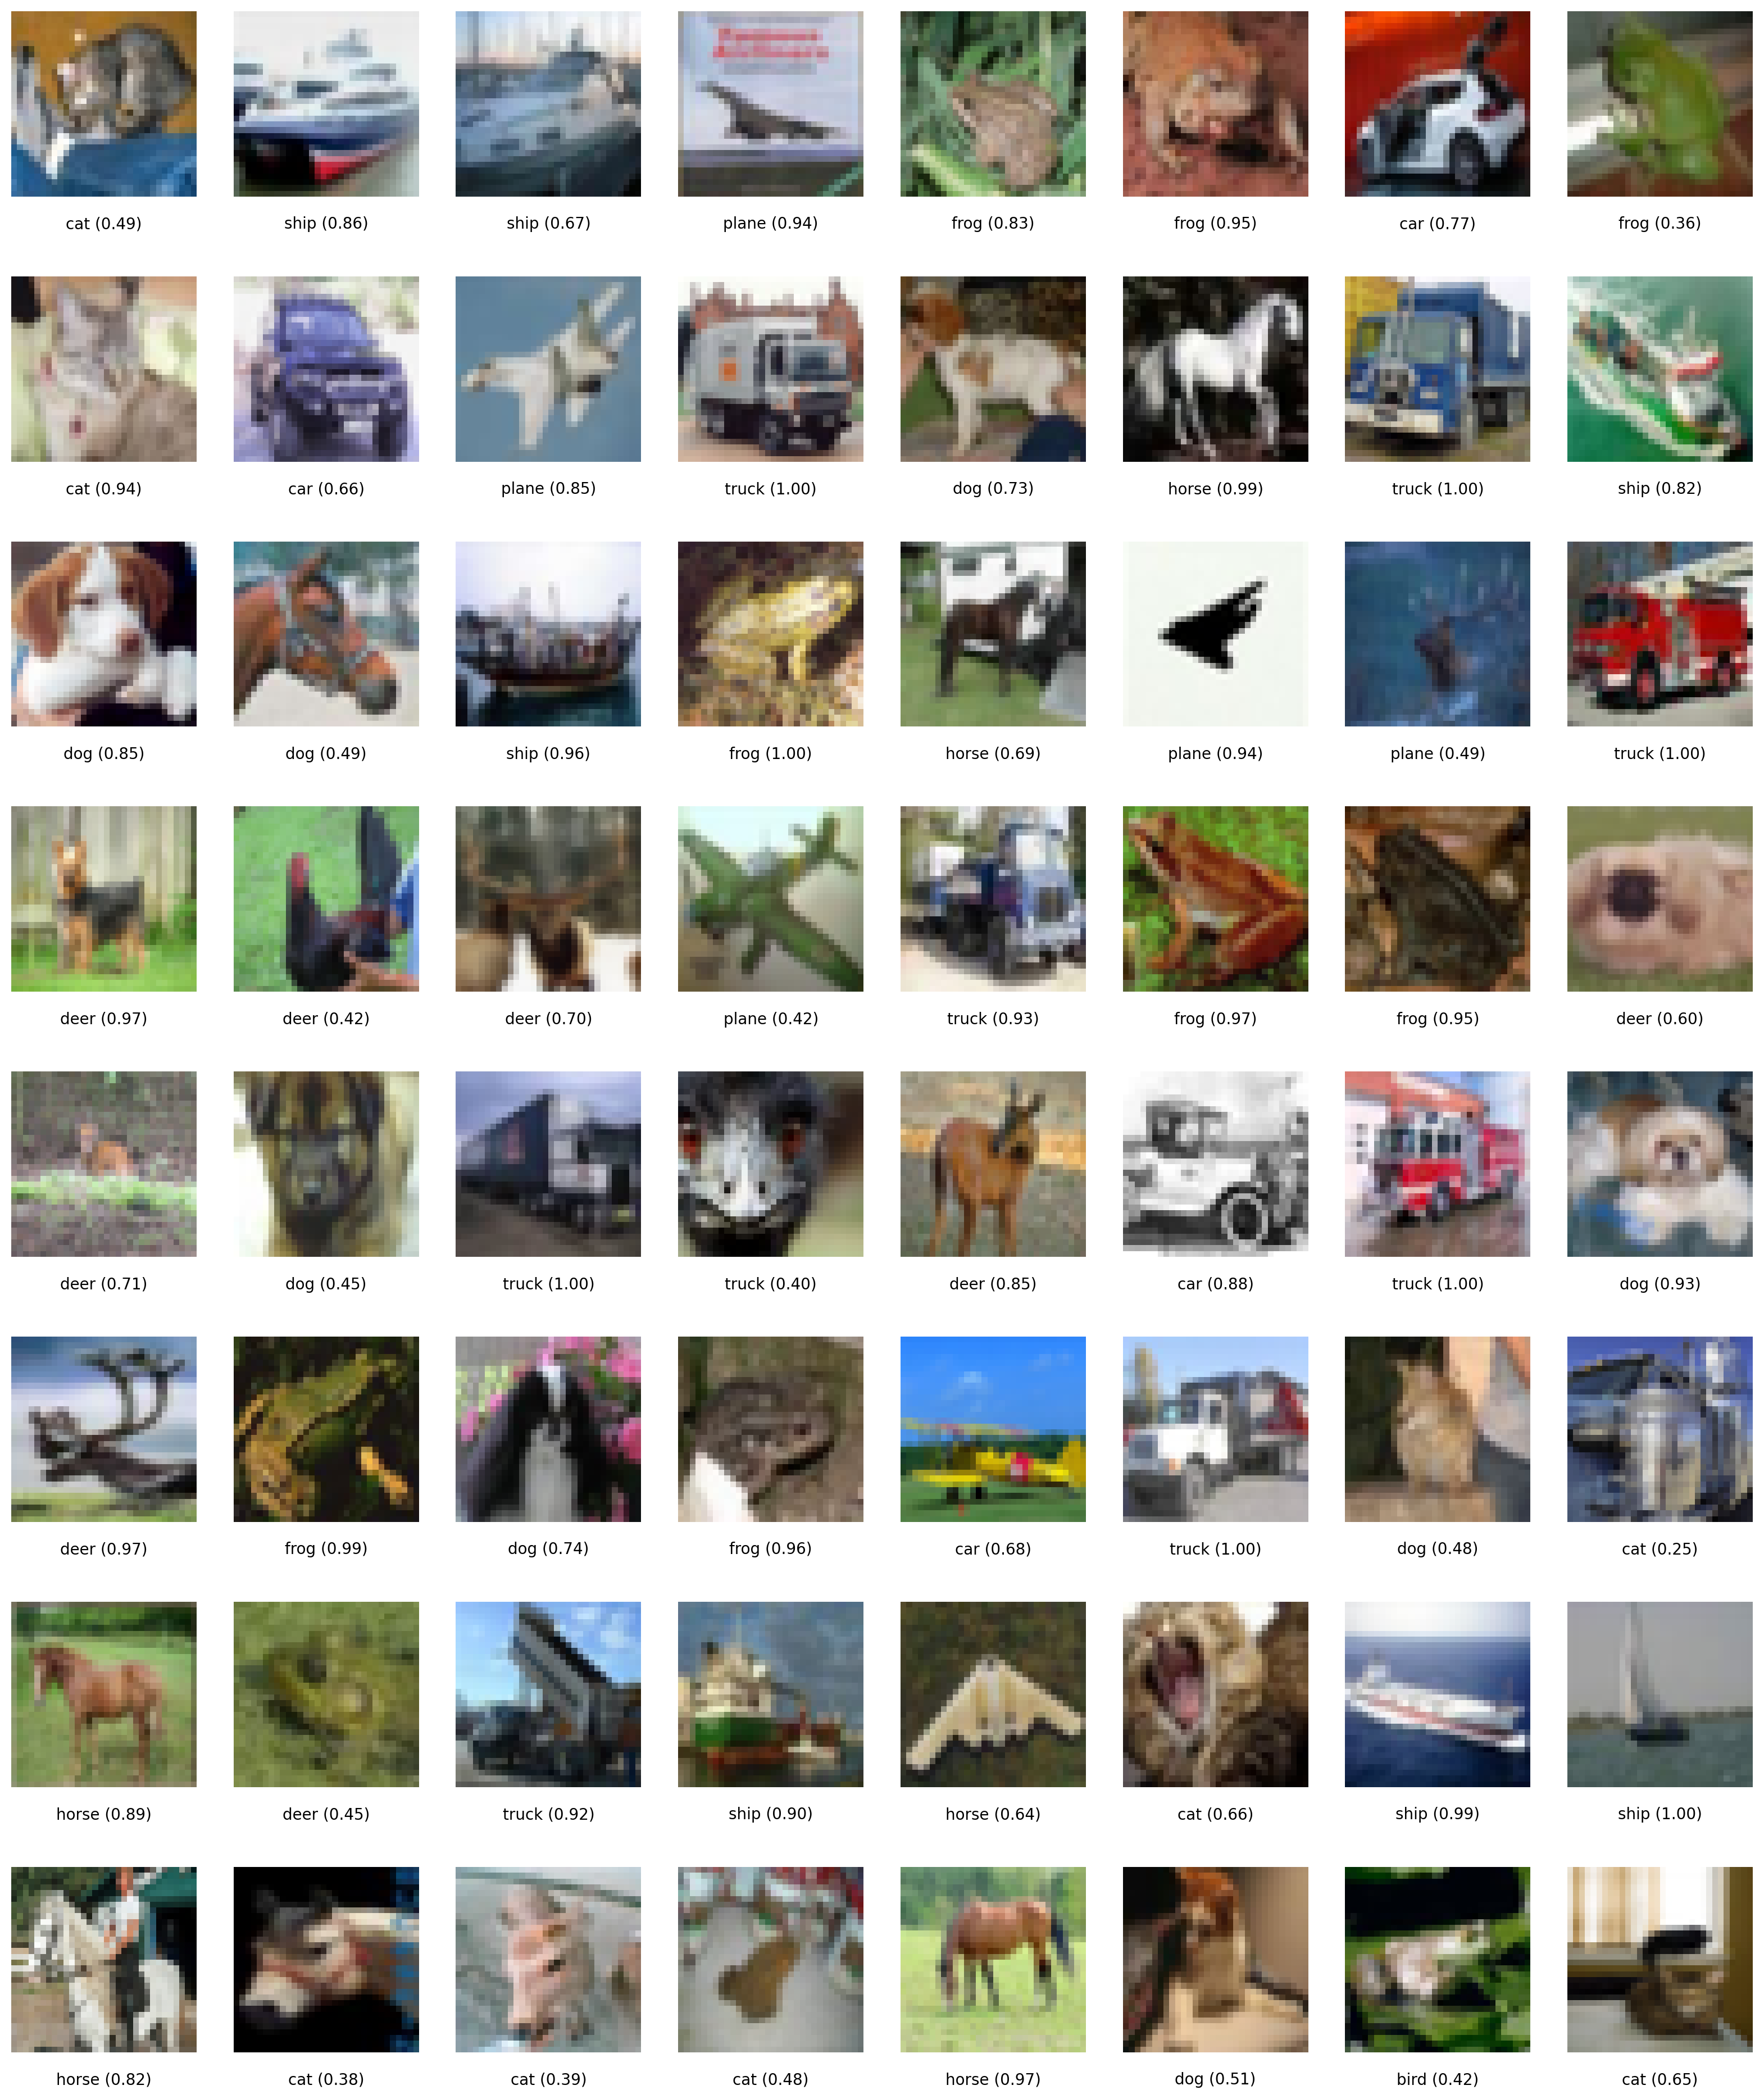

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from base_model import CNN  # 导入CNN标准模型
import math
# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 2. 加载模型 ==========
# 初始化模型
model = CNN().to(device)

# 加载保存的模型权重
model.load_state_dict(torch.load('cifar10_cnn_0.78.pth'))

# ========== 3. 数据预处理 ==========
# 定义数据转换操作: 将PIL图像或ndarray转换为tensor，并归一化到[-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载CIFAR-10测试集
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ========== 4. 预测函数 ==========
def predict_image(model, device, image):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度计算
        image = image.to(device)
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # 计算概率
        _, predicted = output.max(1)  # 获取预测类别
    return predicted.cpu().numpy(), probabilities.cpu().numpy()

# ========== 5. 可视化预测结果 ==========


def imshow(images, predictions, probabilities, labels):
    # 反标准化
    images = images / 2 + 0.5  # 反标准化
    npimages = images.numpy()  # 转换为NumPy数组

    # 获取图片数量
    num_images = len(images)
    
    # 动态计算子图的行数和列数
    cols = 8  # 每行最多显示8张图片
    rows = math.ceil(num_images / cols)  # 向上取整

    # 创建图形和子图
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 3 * rows), dpi=200)  # 动态调整图形大小
    plt.subplots_adjust(wspace=0.2, hspace=0.2)  # 调整子图之间的间隔

    # 如果只有一行，确保axes是一个二维数组
    if rows == 1:
        axes = axes.reshape(1, -1)

    # 遍历所有图片
    for i in range(num_images):
        row = i // cols  # 计算当前图片所在的行
        col = i % cols   # 计算当前图片所在的列

        # 显示图像
        axes[row, col].imshow(np.transpose(npimages[i], (1, 2, 0)), interpolation='nearest')  # 使用最近邻插值
        axes[row, col].axis('off')  # 关闭坐标轴

        # 显示预测结果和可信度
        predicted = classes[predictions[i]]
        confidence = probabilities[i][predictions[i]]  # 获取预测类别的概率
        # 在图像上方添加预测结果文字
        axes[row, col].text(0.5, -0.15, f'{predicted} ({confidence:.2f})', horizontalalignment='center',
                            verticalalignment='center', transform=axes[row, col].transAxes,
                            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # 隐藏多余的子图
    for i in range(num_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')  # 关闭多余的子图

    plt.show()

# ========== 6. 模型评估 ==========
def evaluate_model(model, device, test_loader):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'模型在测试集上的准确率: {accuracy:.2f}%')

# ========== 7. 执行预测和可视化 ==========
# 获取一批测试数据
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 预测结果和可信度
predictions, probabilities = predict_image(model, device, images)
print('Predicted labels: ', predictions)

# 可视化
imshow(images, predictions, probabilities, labels.numpy())

